In [30]:
#reading in csv
salmon=read.csv('salmon.csv')
head(salmon)

install.packages("caret",repos = "http://cran.us.r-project.org")
library('caret')

install.packages("glmnet", repos = "http://cran.us.r-project.org")
library('glmnet')

X,Year,Population_size,Seal_pop,Seattle_pop,Harvested
0,1984,87458,93011,1940000,415773
1,1985,113163,93012,1982000,373350
2,1986,98334,96676,2025000,377386
3,1987,86407,101844,2069000,322433
4,1988,94799,106850,2114000,346779
5,1989,85001,116183,2160000,389584


In [17]:
#normalize pop, seal, seattle, harvested

#df = salmon[,c(3,4,5,6)]
#head(df)

#normalize <- function(x) {
#return ((x - min(x)) / (max(x) - min(x)))
#}

#df_norm<-normalize(df)

#print(df_norm)

In [31]:
#separating data into test and train

set.seed(100)


train<-df[1:21,]
test=df[22:31,]

dim(train)
dim(test)


[1] 21  4

[1] 10  4

In [41]:
#testing linear regression

linear=lm(Harvested ~ Seal_pop+Seattle_pop+Population_size, data=train)
summary(linear)



Call:
lm(formula = Harvested ~ Seal_pop + Seattle_pop + Population_size, 
    data = train)

Residuals:
   Min     1Q Median     3Q    Max 
-53514 -18883  -3191   8169  79977 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      9.136e+05  1.161e+05   7.871 4.55e-07 ***
Seal_pop         3.998e-01  6.787e-01   0.589 0.563590    
Seattle_pop     -3.651e-01  8.717e-02  -4.189 0.000616 ***
Population_size  1.627e+00  2.807e-01   5.795 2.15e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 33940 on 17 degrees of freedom
Multiple R-squared:  0.9248,	Adjusted R-squared:  0.9116 
F-statistic: 69.73 on 3 and 17 DF,  p-value: 9.252e-10


In [33]:
#evaluating linear regression model

#create the evaluation metrics function

eval_metrics = function(model, df, predictions, target){
    resids = df[,target] - predictions
    resids2 = resids**2
    N = length(predictions)
    r2 = as.character(round(summary(model)$r.squared, 2))
    adj_r2 = as.character(round(summary(model)$adj.r.squared, 2))
    print(adj_r2) #Adjusted R-squared
    print(as.character(round(sqrt(sum(resids2)/N), 2)))} #RMSE

#evaluating train data
predictions=predict(linear, newdata = train)
eval_metrics(linear, train, predictions, target = 'Harvested')

#rmse of 0.01 and r-squared of 0.91

[1] "0.89"
[1] "248112.32"


In [34]:
#evaluating linear regression continued

#evaluating test data
predictions = predict(linear, newdata = test)
eval_metrics(linear, test, predictions, target = 'Harvested')

#rmse of 0.05 and r squared of 0.91

[1] "0.89"
[1] "140312.71"


In [43]:
# R program to illustrate 
# Polynomial regression 

poly=Harvested~polym(Seal_pop,Seattle_pop,Population_size,degree=3,raw=TRUE)

summary(poly)


 Length   Class    Mode 
      3 formula    call 

In [36]:
#regularizing the data

cols_reg = c('Population_size', 'Seal_pop', 'Seattle_pop', 'Harvested')

dummies <- dummyVars(log(Harvested) ~ ., data = df[,cols_reg])

train_dummies = predict(dummies, newdata = train[,cols_reg])

test_dummies = predict(dummies, newdata = test[,cols_reg])

print(dim(train_dummies)); print(dim(test_dummies))

[1] 21  3
[1] 10  3


In [38]:
#evaluating ridge regression as a model

library(glmnet)

#creating training variables
x = as.matrix(train_dummies)
y_train = train$Harvested

#creating testing variables
x_test = as.matrix(test_dummies)
y_test = test$Harvested

#creates list of lambda values for model to try
lambdas <- 10^seq(2, -3, by = -.1)

#builds ridge regression model
ridge_reg = glmnet(x, y_train, nlambda = 25, alpha = 0, family = 'gaussian', lambda = lambdas)

#print ridge reg model information
summary(ridge_reg)

          Length Class     Mode   
a0         51    -none-    numeric
beta      153    dgCMatrix S4     
df         51    -none-    numeric
dim         2    -none-    numeric
lambda     51    -none-    numeric
dev.ratio  51    -none-    numeric
nulldev     1    -none-    numeric
npasses     1    -none-    numeric
jerr        1    -none-    numeric
offset      1    -none-    logical
call        7    -none-    call   
nobs        1    -none-    numeric

In [39]:
#ridge regression continued

#finding optimal lambda value
cv_ridge <- cv.glmnet(x, y_train, alpha = 0, lambda = lambdas)
optimal_lambda <- cv_ridge$lambda.min
optimal_lambda

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”

[1] 100

In [40]:
#ridge regression continued

# Compute R^2 from true and predicted values
eval_results <- function(true, predicted, df_norm) {
  SSE <- sum((predicted - true)^2)
  SST <- sum((true - mean(true))^2)
  R_square <- 1 - SSE / SST
  RMSE = sqrt(SSE/nrow(df_norm))

  
  # Model performance metrics
data.frame(
  RMSE = RMSE,
  Rsquare = R_square
)
  
}

# Prediction and evaluation on train data
predictions_train <- predict(ridge_reg, s = optimal_lambda, newx = x)
eval_results(y_train, predictions_train, train)

# Prediction and evaluation on test data
predictions_test <- predict(ridge_reg, s = optimal_lambda, newx = x_test)
eval_results(y_test, predictions_test, test)

#

RMSE,Rsquare
30542.41,0.9248253


RMSE,Rsquare
168907.7,-56.45516


In [26]:
#lasso regression 

#getting optimal lambda
lambdas <- 10^seq(2, -3, by = -.1)

# Setting alpha = 1 implements lasso regression
lasso_reg <- cv.glmnet(x, y_train, alpha = 1, lambda = lambdas, standardize = TRUE, nfolds = 5)

# Best 
lambda_best <- lasso_reg$lambda.min 
lambda_best

[1] 100

In [27]:
#lasso regression continued

#train lasso model
lasso_model <- glmnet(x, y_train, alpha = 1, lambda = lambda_best, standardize = TRUE)

#generate predictions
predictions_train <- predict(lasso_model, s = lambda_best, newx = x)
eval_results(y_train, predictions_train, train)

predictions_test <- predict(lasso_model, s = lambda_best, newx = x_test)
eval_results(y_test, predictions_test, test)

#

RMSE,Rsquare
30549.35,0.9247912


RMSE,Rsquare
169667.1,-56.9729


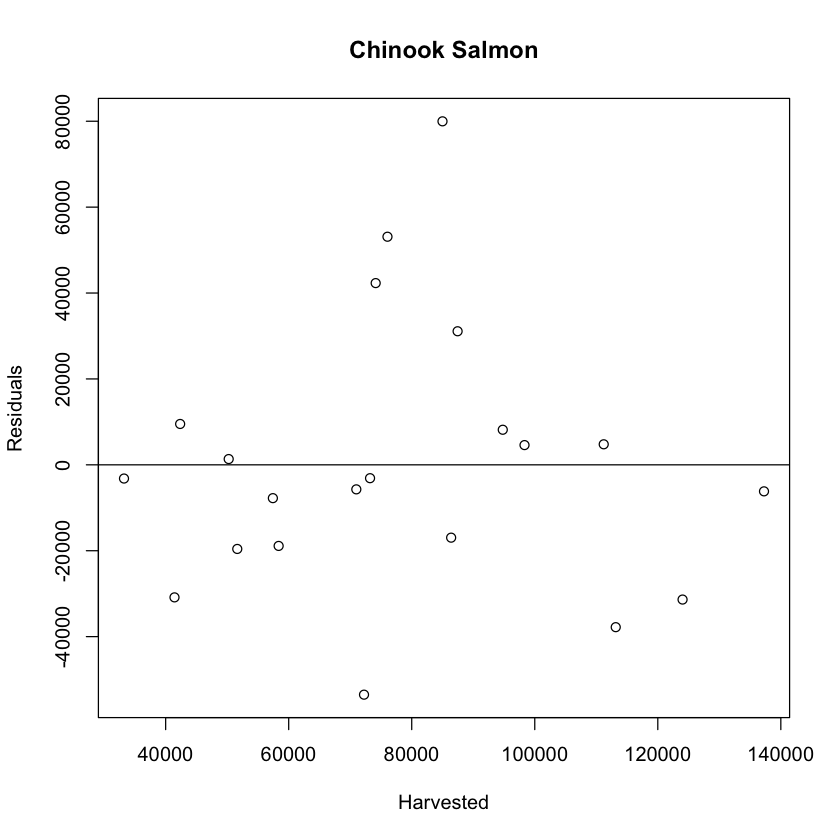

In [28]:
#plotting residual plot to see if there is bias in data
linear=lm(Harvested~ Seal_pop + Seattle_pop+Population_size, data=train)
res=resid(linear)
plot(train$Population_size, res, 
     ylab="Residuals", xlab="Harvested", 
     main="Chinook Salmon") 
abline(0, 0) 

#there is not bias and it is random
#therefore, we can use the above models that assume no bias 
#and normal distribution

In [29]:
print(linear)


Call:
lm(formula = Harvested ~ Seal_pop + Seattle_pop + Population_size, 
    data = train)

Coefficients:
    (Intercept)         Seal_pop      Seattle_pop  Population_size  
      9.136e+05        3.998e-01       -3.651e-01        1.627e+00  

